In [ ]:
from dolfin import *
from mshr import * 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

if not has_linear_algebra_backend("PETSc"):
    print(" It's not configured PETSc")
if not has_slepc():
    print(" It's not configured with SLEPc")

In [ ]:
# Obtain the experimental data from .mat file
import scipy.io as sio
C_mathilde = sio.loadmat('Files_mat/C_values_mathilde.mat')
# Define the constants
# The stiffness constants in [GPa] --> [g/mm(\mu sec)^2]
# are given by the mathilde .mat file of 5%
C11 = np.reshape(C_mathilde['C11'], (30,))*1E-3
C12 = np.reshape(C_mathilde['C12'], (30,))*1E-3
C13 = np.reshape(C_mathilde['C13'], (30,))*1E-3
C33 = np.reshape(C_mathilde['C33'], (30,))*1E-3
C55 = np.reshape(C_mathilde['C55'], (30,))*1E-3
d = np.reshape(C_mathilde['d'], (30,))*1E-3
C_mathilde.keys()

dict_keys(['__header__', 'C66', 'VL_axial', 'C12', '__version__', 'C33', 'VT', 'VL_normal', 'nu', 'C13', 'C55', 'd', 'C11', 'V_plaque', '__globals__'])

In [ ]:
# Rectangle geometry limits
zlim, ylim = 70., 2.8
# Porosity level from Mathilde data 
# this data starts from 1% porosity values!
por = 11 # the porosity level is por+1
# Define domain size 
size = 400
# generate f and create mesh
domain = Rectangle(Point(0., 0.), Point(zlim, ylim))
mesh = generate_mesh(domain, size)
# Compute the minimum height diameter
print("Minimum height of element [mm]: ", mesh.hmin())
#File("Domains/2DMesh.pvd") << mesh

# Define source locations
# Using notation consistent with the 3D-case
nsous = 8
zsous, ysous = [n for n in range(10, 25, 2)], nsous*[ylim,]
# Position of sensor to obtain the force!
nsens = 50# Number of sensors separated at 0.4081 mm
zsens, ysens = np.arange(35, 55, step=0.4), nsens*[ylim,]
# Parameters of Source definition
eps = DOLFIN_EPS
width = 0.5

# Define domain for each source
class DomSource_1(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[0]) < width + eps and
                abs(x[1] - ysous[0]) < width + eps and
                on_boundary)

class DomSource_2(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[1]) < width + eps and
                abs(x[1] - ysous[1]) < width + eps and
                on_boundary)    

class DomSource_3(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[2]) < width + eps and
                abs(x[1] - ysous[2]) < width + eps and
                on_boundary)    

class DomSource_4(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[3]) < width + eps and
                abs(x[1] - ysous[3]) < width + eps and
                on_boundary)    

class DomSource_5(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[4]) < width + eps and
                abs(x[1] - ysous[4]) < width + eps and
                on_boundary)
    
class DomSource_6(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[5]) < width + eps and
                abs(x[1] - ysous[5]) < width + eps and
                on_boundary)
    
class DomSource_7(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[6]) < width + eps and
                abs(x[1] - ysous[6]) < width + eps and
                on_boundary)
    
class DomSource_8(SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0] - zsous[7]) < width + eps and
                abs(x[1] - ysous[7]) < width + eps and
                on_boundary)

    
    
# Define source expression
class Source(Expression):
    def __init__(self, freq, freq_0,
                 sig_freq, degree=1):
        # initialize atributes
        self.freq, self.freq_0 = freq, freq_0
        self.sig_freq = sig_freq
    
    def eval(self, values, x):
        ## Case using Fourier transform with -2*pi on the oscilation
        t_0 = 5.0 # [\mu s]
        sig2 = pow(self.sig_freq,2)
        pi2 = pow(pi,2)
        factor = sqrt(pi*sig2/2)*sin(-2*pi*self.freq*self.freq_0)
        sum_freq = (self.freq_0 + self.freq)
        dif_freq = (self.freq_0 - self.freq)
        # Obtaining left side and right sides
        num_ls = exp(-2*sig2*pi2*pow(sum_freq,2))
        num_rs = exp(-2*sig2*pi2*pow(dif_freq,2))
        values[0] = 0.0 # the horizontal direction
        values[1] = -factor*(num_ls+num_rs) # vertical direction
            
    def value_shape(self):
        return (2,)
    
"""
from IPython.display import HTML
HTML(X3DOM().html(mesh))
"""
print("Number of Cells; {0}, of Vertice: {1}".format(mesh.num_cells(),
                                                  mesh.num_vertices()))

Minimum height of element [mm]:  0.07931657170287836
Number of Cells; 39174, of Vertice: 20193


In [ ]:
# Mark boundaries with label 0
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)

# Mark boundaries (whenever necessary)
# Mark domain sources with 2
DomSource_1().mark(boundaries, 21)
DomSource_2().mark(boundaries, 22)
DomSource_3().mark(boundaries, 23)
DomSource_4().mark(boundaries, 24)
DomSource_5().mark(boundaries, 25)
DomSource_6().mark(boundaries, 26)
DomSource_7().mark(boundaries, 27)
DomSource_8().mark(boundaries, 28)

# Define new measure for boundaries
dx = dx(domain=mesh)
ds = ds(domain=mesh, subdomain_data=boundaries)

# Define function spaces and boundary conditions
pdim = 1
VV = VectorFunctionSpace(mesh, 'CG', pdim)

# Define boundaries over the function space
# In the variational form are defined the Neumann conditions
left_jit = "on_boundary && near(x[0], 0.)"
bc_domain = DirichletBC(VV, Constant((0.,0.)), left_jit)

In [ ]:
# Define kronecker delta in 2D and indices
delta = Identity(2)
i,j,k,l = indices(4)

# Define strain tensor
def epsilon(u): 
    return as_tensor(0.5*(u[i].dx(j)+u[j].dx(i)),
                    (i,j))

# Define stiffness tensor C_{i,j,k,l} transverse isotropic
def VoigtToTensor(A):
    # We use the convention, for long axis 1
    # Upper diagonal part
    A11, A13, A15 = A[0,0], A[0,1], A[0,2]
    A33, A35 = A[1,1], A[1,2]
    A55 = A[2,2]
    # Lower diagonal part (symmetric)
    A31, A51 = A13, A15
    A53 = A35
    
    return as_tensor([\
           [\
            [ [A11, A15], [A15, A13]] ,\
            [ [A51, A55], [A55, A53]] \
           ], \
           [
            [ [A51, A55], [A55, A53]] ,\
            [ [A31, A35], [A35, A33]] \
           ] \
                     ])

# We take the standard density
rho = d[por] # [g/cm^3] --> [g/(mm)^3]
# Define the Voigt matrix representing the tensor
# Here, the 3-axis is the z-axis, and
# 1-axis in the y-axis or x-axis by the simmetry
C_voigt = np.array([\
                   [C33[por], C13[por], 0], \
                   [C13[por], C11[por], 0], \
                   [0, 0, C55[por]] 
                   ])
# Obtain the stiffness tensor
C = VoigtToTensor(C_voigt)
# Define stress tensor
def sigma(u):
    return as_tensor(C[i,j,k,l]*epsilon(u)[k,l], 
                     (i,j))

## Study of the Eigenvalues for the Elastic Operator

In [ ]:
# Define eigenvalue function 
def eigen_values(V, bcs, target_freq):
    # First, define the variational forms
    u = TrialFunction(V)
    v = TestFunction(V)
    A_lhs = inner(sigma(u), grad(v))*dx
    B_rhs = inner(u,v)*dx
    
    # Second, assemble the bilinear forms into PETSc
    # matrices A, B to obtain matrix eigenvalue problem
    dummy = v[0]*dx
    A = PETScMatrix()
    # assemble_system weeks symmetry
    assemble_system(A_lhs, dummy, bcs, A_tensor=A)
    B = PETScMatrix()
    assemble_system(B_rhs, dummy, bcs, A_tensor=B)
    
    # Third, we add the zeros of B, corresponding to the
    # constrained boundary degrees of freedom
    [bc.zero(B) for bc in bcs]
    
    # Fourth, define the SLEPcEigenSolver
    solver = SLEPcEigenSolver(A, B)
    solver.parameters["solver"] = "krylov-schur"
    #solver.parameters["problem_type"] = "gen_hermitian"
    
    # Fifth, specify the 4 eigenvalues nearest to the
    # target frequencies
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    # convert to lambda target
    target_lambda = pow(2*np.pi*target_freq,2)*rho
    solver.parameters["spectral_shift"] = target_lambda
    # Number of neighbours
    neigs = 6
    info(solver, True)
    solver.solve(neigs)
    
    # Sixth, compute the eigenvalues in a sorted way
    # scaled to be frequencies
    comp_eigenvalues = []
    # save the frequencies associated to eigenvalues
    min_range = min(neigs, solver.get_number_converged())
    for n in range(min_range):
        # just save the real part
        eig_real, _ = solver.get_eigenvalue(n)
        freq_real = np.sqrt(eig_real/rho)/(2*np.pi)
        comp_eigenvalues.append(freq_real)
    
    # returns the values sorted
    return np.sort(np.array(comp_eigenvalues))

In [ ]:
## TEST CASE FOR 3 FREQUENCIES
# Frequency array to consider
freqs = np.arange(0., 2., step=20./2048)# ~ [MHz]
# Obtain first 10 eigenvalues of operator -div(sigma(u))
# close to the first 10 frequencies
bcs = [bc_domain]
for freq in [freqs[30], freqs[35], freqs[40]]:
    eigen_freqs = eigen_values(VV, bcs, freq)
    print("Freq. from array: {0}".format(freq))
    print("Absolute difference wrt array freq.")
    print(np.abs(freq-eigen_freqs))

Freq. from array: 0.29296875
Absolute difference wrt array freq.
[ 0.01461374  0.01002012  0.00194105  0.01055437  0.01180583  0.02260241]
Freq. from array: 0.341796875
Absolute difference wrt array freq.
[ 0.01117277  0.00485802  0.00117659  0.00351208  0.00556414  0.01018902]
Freq. from array: 0.390625
Absolute difference wrt array freq.
[ 0.01015253  0.00549903  0.00065495  0.0050682   0.0079462   0.0131881 ]


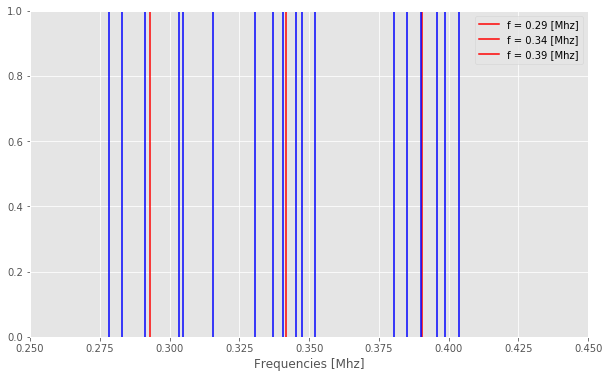

In [ ]:
# plot of the obtained freqs and eigen_freqs
plt.figure(figsize=(10,6))
for freq in [freqs[30], freqs[35], freqs[40]]:
    eigen_freqs = eigen_values(VV, bcs, freq)
    plt.axvline(x = freq, label='f = {:.2f} [Mhz]'.format(freq),
                color = 'r')
    for eigen_freq in eigen_freqs:
        plt.axvline(x = eigen_freq,
                    color = 'b')

plt.xlim([0.25, 0.45])
plt.xlabel("Frequencies [Mhz]")
plt.legend(loc='best')
for _ in ['.pdf', '.png']:
    filename = 'Eigen3FreqsComparison'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')

### Now, compute all the eigen-freqs in the freq. array

In [ ]:
# Save all eigen frequencies found at each freq array
eigen_freqs = np.zeros((len(freqs), 6))
m = 0 # start a counter to save each eigen-freqs.
for freq in freqs:
    aux = eigen_values(VV, bcs, freq)
    eigen_freqs[m, :] = aux
    m += 1

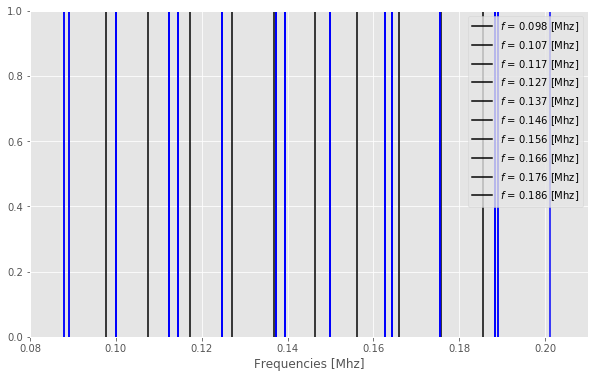

In [ ]:
# Define plot figure
plt.figure(figsize=(10,6))
# Plot first the frequency array
for freq in freqs[10:20]:
    plt.axvline(x = freq, label='$f$ = {:.3f} [Mhz]'.format(freq),
                color = 'k') # Recall 'k' is black color
for ll in range(10, 20):
    for eigen_freq in eigen_freqs[ll, :]:
        plt.axvline(x = eigen_freq, color = 'b')
    ll += 1

        
plt.xlim([0.08, 0.21])
plt.xlabel("Frequencies [Mhz]")
plt.legend(loc='best')
for _ in ['.pdf', '.png']:
    filename = 'EigenFreqsComparison'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')

### Animation generation of Eigen-Frequencies

In [ ]:
round(1.326451, 3)

1.326

In [ ]:
def EigenFreqsPlot(freqs_array, eigenfreq_array, nfreqlines, filename):
    """
    It creates a figure of the eigenvalues within a neighborhood of the freq
    array for animation purposes.
    """
    # Define plot figure
    plt.figure(figsize=(8,5))
    
    # Plot first the frequency array
    for freq_id in range(nfreqlines-5, nfreqlines):
        freq = freqs_array[freq_id]
        plt.axvline(x = freq, label='$f$ = {:.3f} [Mhz]'.format(freq),
                    color = 'r')
        for eigen_freq in eigenfreq_array[freq_id, :]:
            plt.axvline(x = eigen_freq, color = 'b')

    # Plot visual configuration and saving!
    min_val = round(min(freqs_array[nfreqlines-6:nfreqlines+1]), 3)
    max_val = round(max(freqs_array[nfreqlines-6:nfreqlines+1]), 3)
    
    plt.xlim([min_val, max_val])
    plt.xlabel("Frequencies [Mhz]")
    plt.gca().yaxis.set_ticklabels([])
    plt.legend(loc='upper right')
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close()

In [ ]:
# Iterate over each eigenfrequency and plot the results
fnames = []
for step in range(10, 200, 2):
    filename = 'temp/_anim%d' % step
    EigenFreqsPlot(freqs, eigen_freqs, step, filename)
    # Append file names for deletion
    fnames.append(filename)

## Solving the elastodynamic problem

In [ ]:
# Define the three main blocks in variational forms
def o_block(u, v, omega):
    return -rho*pow(omega,2)*inner(u, v)*dx

def A_block(u, v):
    return inner(sigma(u), grad(v))*dx

def b_block(source, v, bdry_id):
    return dot(source, v)*ds(bdry_id)

# Frequency array to consider
freqs = np.arange(0., 2., step=20/2048)# ~ [MHz], step=20/2048
omegas = 2*pi*freqs
# Define number of frequencies
nfreq = freqs.shape[0]
# Define sensors arrays
sol_sensors_z = np.zeros((nsens, nfreq, nsous))
sol_sensors_y = np.zeros((nsens, nfreq, nsous))

# Print number of point at the boundary
print("Total number of points at the boundary", 
      len(bc_domain.get_boundary_values()))

# Check the points where the force is applied
mesh_points = SubsetIterator(boundaries, 28)
print("Midpoints where the force is applied")
for data in mesh_points:
    print("Points at boundary 28, ({0},{1}) ".format(
          data.midpoint().x(), data.midpoint().y()))


Total number of points at the boundary 66
Midpoints where the force is applied
Points at boundary 28, (23.994140625,2.8) 
Points at boundary 28, (24.130859375,2.8) 
Points at boundary 28, (23.5498046875,2.8) 
Points at boundary 28, (24.3017578125,2.8) 
Points at boundary 28, (24.3701171875,2.8) 
Points at boundary 28, (23.857421875,2.8) 
Points at boundary 28, (23.720703125,2.8) 
Points at boundary 28, (24.2333984375,2.8) 
Points at boundary 28, (24.4384765625,2.8) 
Points at boundary 28, (23.6181640625,2.8) 


In [ ]:
## Iterate of freq. and solution saving for a point sensor
# Define trial and test functions
u = TrialFunction(VV)
v = TestFunction(VV)

# list all boundaries
bcs = [bc_domain]

# Define name solutions for saving with File
#filename = "SimP"+str(por+1)+"TransIso"+str(ylim)+ \
#           "M"+str(size)+"Freq.pvd"
#filepvd ="Results/"+filename
#vtk_u = File(filepvd)
    
# Iteration over each frequency
for freq_i in range(nfreq):
    ## Define Neumann boundary condition for source 
    freq, freq_0 = float(freqs[freq_i]), 0.5#freq_0 ~ 1 [MHz]
    # Define general variance
    sig_freq = 0.7 # sig_freq ~ 0.7 [Mhz]
    source_exp = Source(freq=freq, freq_0=freq_0,
                        sig_freq=sig_freq, degree=1)
    # Interpolate source over domain
    source = interpolate(source_exp, VV)

    # Variational forms
    A_lhs = o_block(u,v,omegas[freq_i]) + A_block(u,v)
    A = assemble(A_lhs)
    # Apply source sequentially 
    for sous_j in range(nsous):   
        # Define function-solution
        u_sol = Function(VV)
        # Compute bounda ry layer
        bdry_id = int(21 + sous_j)
        b_rhs = b_block(source, v, bdry_id)
        
        # Assemble of matrices
        b = assemble(b_rhs)
        # Apply boundary conditions
        [bc.apply(A,b) for bc in bcs]
        # DEBUG!
        #print("Value rhs: ", np.linalg.norm(np.array(b), ord=2))
        # Solve the variational problem
        solve(A, u_sol.vector(), b)
            
        # Compute data at the sensors and save it as array
        for sens_k in range(nsens):
            # Obtain point value of solution u
            sensor_point = Point(np.array((zsens[sens_k], ysens[sens_k])))
            # Save data values at the sensor location
            sol_sensors_z[sens_k, freq_i, sous_j] = u_sol(sensor_point)[0]
            sol_sensors_y[sens_k, freq_i, sous_j] = u_sol(sensor_point)[1]
            
        if sous_j == 0:
            # Save vtk solution
            #vtk_u << (u_sol, float(freq_i))   
            # Print some info about the solutions
            print("Value at sensor: {0}, with freq: {1:.3f} [MHz]".format(
                  u_sol(sensor_point)[1], freq))
            #print("Value rhs", np.linalg.norm(b, ord=2))


Value at sensor: 0.0, with freq: 0.000 [MHz]
Value at sensor: 22.444163543824708, with freq: 0.010 [MHz]
Value at sensor: 8.870199419373824, with freq: 0.020 [MHz]
Value at sensor: 1.7245756271049493, with freq: 0.029 [MHz]
Value at sensor: -4.332277480429571, with freq: 0.039 [MHz]
Value at sensor: 1.631020876314226, with freq: 0.049 [MHz]
Value at sensor: 1.794863016619097, with freq: 0.059 [MHz]
Value at sensor: -2.3258128976841608, with freq: 0.068 [MHz]
Value at sensor: -2.884544586445431, with freq: 0.078 [MHz]
Value at sensor: -170.3714025845913, with freq: 0.088 [MHz]
Value at sensor: 12.785394954194091, with freq: 0.098 [MHz]
Value at sensor: -6.28405842285234, with freq: 0.107 [MHz]
Value at sensor: 2.6925917755444244, with freq: 0.117 [MHz]
Value at sensor: -0.31805046276922005, with freq: 0.127 [MHz]
Value at sensor: -6.5328468380534925, with freq: 0.137 [MHz]
Value at sensor: 6.145236498021924, with freq: 0.146 [MHz]
Value at sensor: -8.108887775890425, with freq: 0.156 [M

Value at sensor: 0.006590037311007919, with freq: 1.328 [MHz]
Value at sensor: 0.0155793721288327, with freq: 1.338 [MHz]
Value at sensor: 0.010116711317774245, with freq: 1.348 [MHz]
Value at sensor: 0.05370283162217038, with freq: 1.357 [MHz]
Value at sensor: -0.008650525954943769, with freq: 1.367 [MHz]
Value at sensor: 0.037839971371520835, with freq: 1.377 [MHz]
Value at sensor: 0.005872609861195944, with freq: 1.387 [MHz]
Value at sensor: -0.006333338473268783, with freq: 1.396 [MHz]
Value at sensor: -0.000805560167973023, with freq: 1.406 [MHz]
Value at sensor: 0.006850974596933803, with freq: 1.416 [MHz]
Value at sensor: -0.025478441261972518, with freq: 1.426 [MHz]
Value at sensor: -0.003632844081327807, with freq: 1.436 [MHz]
Value at sensor: 0.03301488918366721, with freq: 1.445 [MHz]
Value at sensor: 0.004387222802257466, with freq: 1.455 [MHz]
Value at sensor: -0.002614834968074271, with freq: 1.465 [MHz]
Value at sensor: 0.0019186985886450706, with freq: 1.475 [MHz]
Value

Min: -3364.217064759382, and Max: 879.3151934786462 (example)


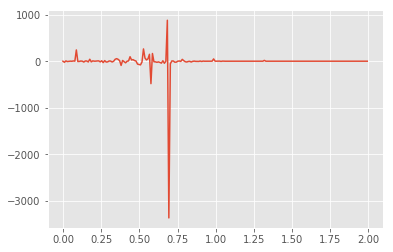

In [ ]:
# [sensor_id, freq_id, sous_id]
print("Min: {0}, and Max: {1} (example)".format( 
      np.min(sol_sensors_y[0, :, 0]), 
      np.max(sol_sensors_y[0, :, 0])))

plt.plot(freqs, sol_sensors_y[0, :, 0])
#plt.ylim([-100, 100])

In [ ]:
import scipy.io as sio
# create dictionary with variables to save
savedic = {'zlim': zlim, 'ylim': ylim, 'nsous': nsous,
          'zsous': zsous, 'ysous': ysous, 'nsens': nsens,
          'zsens': zsens, 'ysens': ysens, 'nfreq': nfreq,
          'freqs': freqs, 'omegas': omegas,
          'sol_sensors_z': sol_sensors_z, 'sol_sensors_y': sol_sensors_y,
          'eigen_freqs': eigen_freqs}
filename = 'Files_mat/SimFreqRes_P'+str(por+1)+'TransIsoW'+ \
           str(ylim)+'M'+str(size)
sio.savemat(filename, savedic, appendmat=True)

In [ ]:
# Cell created just for testing and recovering purposes
import scipy.io as sio
import numpy as np
saved_file = 'SimFreqRes_P'+str(por+1)+'TransIsoW'+ \
              str(ylim)+'M'+str(size)+'.mat'
data = sio.loadmat('Files_mat/'+saved_file)

sol_sensors_z = data['sol_sensors_z']
sol_sensors_y = data['sol_sensors_y']
nsens = int(data['nsens'])
nsous = int(data['nsous'])
nfreq = int(data['nfreq'])
freqs = np.reshape(data['freqs'], (np.size(data['freqs']),))
omegas = np.reshape(data['omegas'], (np.size(data['omegas']),))
data.keys()

dict_keys(['__header__', 'ylim', 'eigen_freqs', 'nsens', 'sol_sensors_y', '__version__', 'nsous', 'omegas', 'ysens', 'zsens', 'nfreq', 'zsous', 'sol_sensors_z', 'ysous', 'zlim', 'freqs', '__globals__'])

In [ ]:
def NormSVB(f_id, k, iFU, M):
    """
    Generate norm(f,k) = \sum_{i=0}^m |iFU[freq]|_k 
    given 3d Fourier data of:  iFU(f_id) = (iFU_1 | iFU_2|...|iFU_{N_E}), 
    f_id: frequency, k: wavenumber, M: Parameters to adjust mannualy
    
    Input: iFU 3d array
    Return: NormSVB for each k wavenumber
    """
    norm_fk = float(0) # to save to norm value
    
    # Iterate over the first M columns of U
    for m in range(M):
        norm_fk += np.absolute(iFU[k, f_id, m])
    return norm_fk

def dB_signal(sous_id, signal):
    """
    The input signal has dim: (nsous,nfreq)
    """
    return 20*np.log10(signal[sous_id, :])


In [ ]:
## Take just sensors separated at 0.4081 [mm]
from scipy.signal import hilbert
# Sizes of sol_signal \in N_R \times N_freq \times N_E
# Amount of wavenumber to consider
nwavenums = 256*2
# Create 3d array to store svd for each freq
Rc_z = np.zeros((nsens, nfreq, nsous), dtype=complex)
Rc_y = np.zeros((nsens, nfreq, nsous), dtype=complex)
# and iFU : the inverse fourier transform
U_z = np.zeros((nsens, nfreq, nsens), dtype=complex)
U_y = np.zeros((nsens, nfreq, nsens), dtype=complex)
iFU_z = np.zeros((nwavenums, nfreq, 15), dtype=complex)
iFU_y = np.zeros((nwavenums, nfreq, 15), dtype=complex)
sig_z = np.zeros((nsous,nfreq), dtype=float)
sig_y = np.zeros((nsous,nfreq), dtype=float)

for freq in range(nfreq):
    # Decomposition using SVB
    Rc_z[:,freq,:] = hilbert(sol_sensors_z[:,freq,:], axis=0)
    Rc_y[:,freq,:] = hilbert(sol_sensors_y[:,freq,:], axis=0)
    U_z[:,freq,:], sig_z[:,freq], V = np.linalg.svd(Rc_z[:,freq,:], full_matrices=True)
    U_y[:,freq,:], sig_y[:,freq], V = np.linalg.svd(Rc_y[:,freq,:], full_matrices=True)
    # Compute space fourier transform, using first axis
    iFU_z[:,freq,:] = np.fft.ifft(U_z[:,freq,0:15], 
                                  n=nwavenums, axis=0, norm='ortho') 
    iFU_y[:,freq,:] = np.fft.ifft(U_y[:,freq,0:15], 
                                  n=nwavenums, axis=0, norm='ortho')
    

# Consider only the first M principal signals
M = [1, 2, 4, 6]
    
# Define matrix of solutions
matrix_fk_z = np.zeros((nfreq, nwavenums, len(M)))
matrix_fk_y = np.zeros((nfreq, nwavenums, len(M)))

# Obtain norm for each frequency and wavenumber
for f_id, wv_id, M_id in np.ndindex(matrix_fk_z.shape):
    matrix_fk_z[f_id, wv_id, M_id] = NormSVB(f_id, wv_id, iFU_z, M[M_id])
    matrix_fk_y[f_id, wv_id, M_id] = NormSVB(f_id, wv_id, iFU_y, M[M_id])
    if f_id == 10 and wv_id == 5:
        print("Computing for freq: {0:.2f}".format(
              omegas[f_id]))
        print(" Value of NormSVB at this stage: {0:2.3f}".format(
              matrix_fk_z[f_id, wv_id, M_id]))


Computing for freq: 0.61
 Value of NormSVB at this stage: 0.021
Computing for freq: 0.61
 Value of NormSVB at this stage: 0.113
Computing for freq: 0.61
 Value of NormSVB at this stage: 0.385
Computing for freq: 0.61
 Value of NormSVB at this stage: 0.427


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


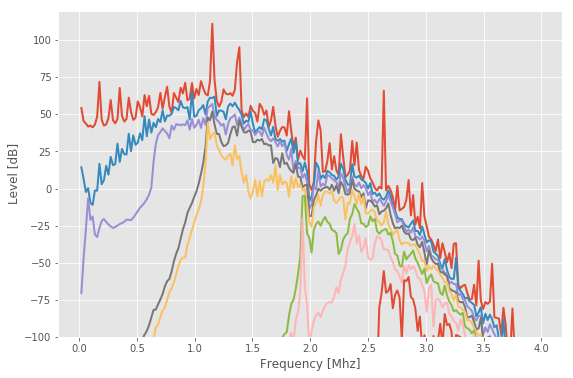

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
fig.subplots_adjust(left = 0.2, wspace = 0.4, hspace = 0.4)
# Obtain sampling frequencies (of FFT) 
freqs = np.fft.fftfreq(n = 1024, d = 1/20)[:205]
for sous_id in range(nsous):
    leg_id = "Id: "+str(sous_id)
    if sous_id <= 4:
        axes.plot(freqs, dB_signal(sous_id, sig_y).real, label=leg_id,
                  linewidth=2)
    else:
        axes.plot(freqs, dB_signal(sous_id, sig_y).real,
                  linewidth=2)

axes.set_ylim([-100, 120])
# Add legend
#axes.legend(loc="best")
# Add axes names and savefig
axes.set_ylabel("Level [dB]")
axes.set_xlabel("Frequency [Mhz]")

for _ in ['.pdf', '.png']:
    filename = 'Plots/2DFreqS8'+str(por+1)+'Elastic'+ \
               str(ylim)+'_SV'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# We load mat file of k values at different porosities
# data['por2'] array of size(n_freqs, n_modes, n_thickness)
Data_REF2D = sio.loadmat('Files_mat/k_REF2D_Datapy.mat')
# Define data of porosities, as the 4-D array
# [Por, Freq, k_val, width] --> shape [30,205,12,103]
DataFreqs = np.reshape(Data_REF2D['f'], (205,))
DataPor = Data_REF2D['k_ref2D_Data']
lim = np.max(DataFreqs)

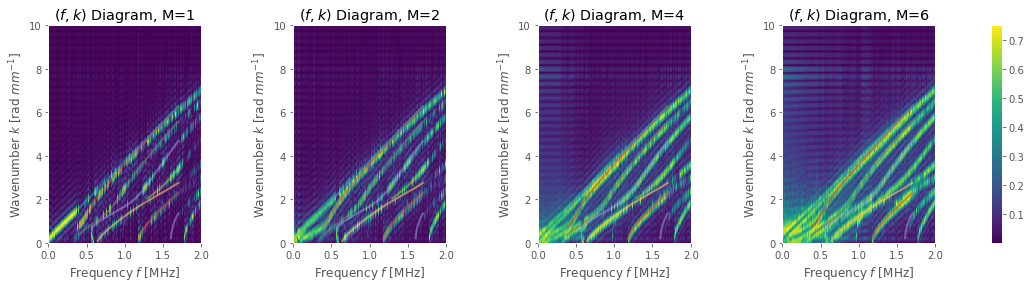

In [ ]:
# Obtain index for data arrays
index_th = lambda x: int(round(x*10-8,2)//0.5)+int(round(ylim*10-8,2)%0.5)
th = index_th(ylim)
# Define first the theoretical k_max, where 0.4 denotes
# the distance between sensors
lim = 2*np.pi/(0.4)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22,4))
fig.subplots_adjust(left = 0.2, wspace = 0.6)
i = 0
for ax in axes.flat: 
    im = ax.imshow(matrix_fk_y[: , :, i].T, extent=[0, 2, 0, lim], 
                   aspect='auto')
    ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2, alpha=0.6)
    ax.grid()
    ax.set_xlabel('Frequency $f$ [MHz]')
    ax.set_ylabel('Wavenumber $k$ [rad $mm^{-1}$]')
    ax.set_xlim([0., 2.])
    ax.set_ylim([0., 10])
    ax.set_title('$(f,k)$ Diagram, M='+str(M[i]))
    i += 1

fig.colorbar(im, ax=axes.ravel( ).tolist())
for _ in ['.pdf', '.png']:
    filename = 'Plots/2DFreqS8P'+str(por+1)+'ElasticFK'+ \
               str(ylim)+'M'+str(size)+'_y'+_
    plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

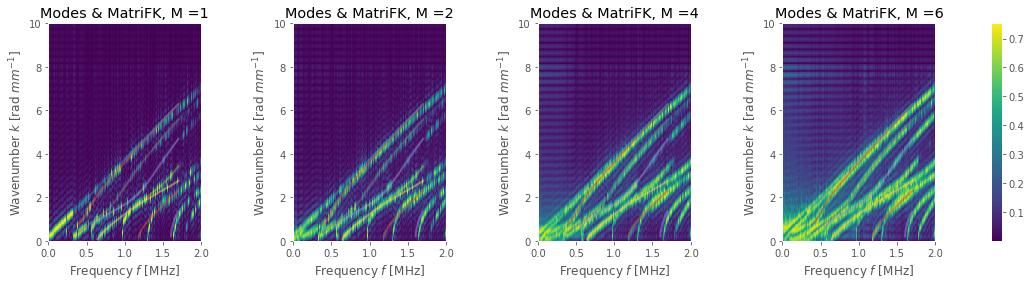

In [ ]:
# Obtain index for data arrays
index_th = lambda x: int(round(x*10-8,2)//0.5)+int(round(ylim*10-8,2)%0.5)
th = index_th(ylim)
# Define first the theoretical k_max, where 0.4 denotes
# the distance between sensors
lim = 2*np.pi/(0.4)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22,4))
fig.subplots_adjust(left = 0.2, wspace = 0.6)
i = 0
for ax in axes.flat: 
    im = ax.imshow(matrix_fk_z[: , :, i].T, extent=[0, 2, 0, lim], 
                   aspect='auto')
    ax.plot(DataFreqs, DataPor[por, :, :, th], linewidth=2, alpha=0.5)
    ax.grid()
    ax.set_xlabel('Frequency $f$ [MHz]')
    ax.set_ylabel('Wavenumber $k$ [rad $mm^{-1}$]')
    ax.set_xlim([0., 2.])
    ax.set_ylim([0., 10])
    ax.set_title('Modes & MatriFK, M ='+str(M[i]))
    i += 1

fig.colorbar(im, ax=axes.ravel( ).tolist())
#for _ in ['.pdf', '.png']:
#    filename = 'Plots/2DFreqS8P'+str(por+1)+'ElasticFK'+ \
#               str(ylim)+'M'+str(size)+'_z'+_
#    plt.savefig(filename, dpi=150, bbox_inches='tight')
plt.show()

Text(0.5,0,'Frequencies [Mhz]')

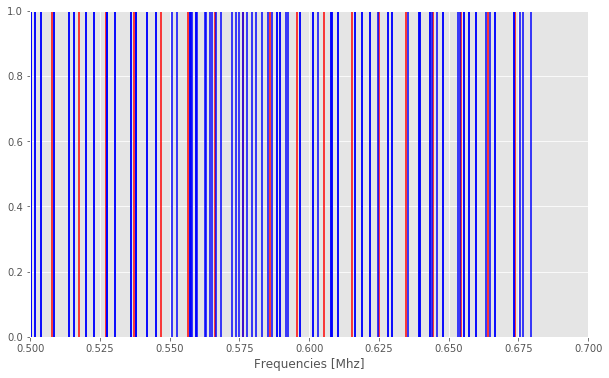

In [ ]:
plt.figure(figsize=(10,6))
for freq in freqs[50:70]:
    plt.axvline(x = freq, color = 'r')
for ll in range(50, 70):
    for eigen_freq in eigen_freqs[ll, :]:
        plt.axvline(x = eigen_freq, color = 'b')
plt.xlim([0.5, 0.7])
plt.xlabel("Frequencies [Mhz]")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


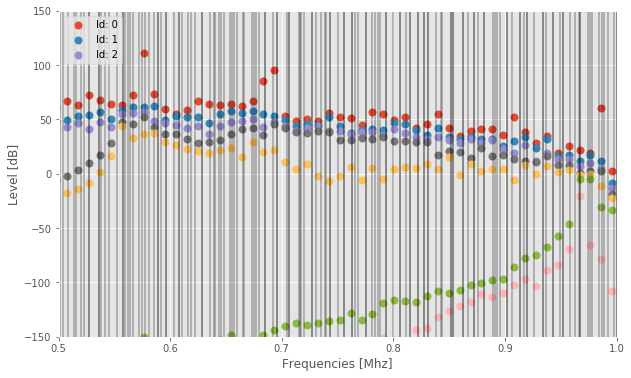

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
for sous_id in range(nsous):
    label_id = "Id: " + str(sous_id)
    if sous_id <= 2:
        axes.scatter(freqs, dB_signal(sous_id, sig_y), label=label_id, 
                     linewidth=2)
    else:
        axes.scatter(freqs, dB_signal(sous_id, sig_y), 
                     linewidth=2)
    

for ll in range(nfreq):
    for eigen_freq in eigen_freqs[ll, ::2]:
        axes.axvline(x = eigen_freq, color = 'k', alpha=0.3)

axes.set_xlim([0.5, 1.0])
axes.set_ylim([-150, 150])
axes.set_ylabel("Level [dB]")
axes.set_xlabel("Frequencies [Mhz]")
# Add legend and savefig
axes.legend(loc='best')
#for _ in [".pdf", ".png"]:
#    plt.savefig("Plots/SingValues-EigenFreqs05-10"+_, dpi=150, bbox_inches='tight')

## Animation figures of eigenvalues on the recorded modes

In [ ]:
def EigenModesPlot(freqs_array, eigenfreq_array, nfreqlines, filename):
    """
    It creates a figure of the eigenvalues within the modes figures 
    for further animation creation!
    """
    # Define figure to plot
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    labels = []
    for sous_id in range(nsous-3):
        label_id = "Id: " + str(sous_id)
        labels.append(label_id)
        axes.scatter(freqs, dB_signal(sous_id, sig_y), 
                     linewidth=2)
    
    axes.legend(labels, loc='upper left')
    # Plot first the frequency array
    for freq_id in range(nfreqlines-10, nfreqlines):
        for eigen_freq in eigenfreq_array[freq_id, :]:
            plt.axvline(x = eigen_freq, color = 'b', alpha=0.3)

    # Plot visual configuration and saving!
    min_val = round(min(freqs_array[nfreqlines-10:nfreqlines+2]), 3)
    max_val = round(max(freqs_array[nfreqlines-10:nfreqlines+2]), 3)
    
    axes.set_xlim([min_val, max_val])
    axes.set_ylim([-50, 100])
    axes.set_xlabel("Frequencies [Mhz]")
    axes.set_ylabel("Level [dB]")
    #axes.legend(loc='upper right')
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.close()

In [ ]:
# Iterate over each eigenfrequency and plot the results
fnames = []
for step in range(200, 205, 2):
    filename = 'temp/_tmp%d' % step
    EigenModesPlot(freqs, eigen_freqs, step, filename)
    # Append file names for deletion
    fnames.append(filename)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


## Selection of "good" frequencies

In [ ]:
# We'll consider frequencies for the simulations
# at epsilon of a eigen-frequency
def stable_frequencies(freqs, eigen_freqs, epsilon,
                       direction):
    # Initialize stable array of frequencies
    stable_freqs = np.zeros_like(freqs)
    # Iteratation over each frequency
    for ll in range(len(freqs)):
        # Iteartion over eigen-frequencies 
        # associated to freq freqs[ll]
        for eig_freq in eigen_freqs[ll, :]:
            # Separate not eigen-frequencies from freqs.
            eig_dif = np.abs(eig_freq - freqs[ll])
            # If difference is > epsilon, choose array freq.
            if eig_dif > epsilon:
                stable_freqs[ll] = freqs[ll]
            # Otherwise
            else:
                min_value = min(eig_dif/2, epsilon/2)
                # move forward the freq. in min_value
                if direction == 'forward':
                    stable_freqs[ll] = freqs[ll]+min_value
                else:
                    stable_freqs[ll] = freqs[ll]-min_value
                
    return stable_freqs

In [ ]:
# Compute the new array of frequencies using stable-freqs.
# OBS: for epsilon = 0.02 works reasonable!.
epsilon = 0.02 # checked from the above computations
stable_freqs = stable_frequencies(freqs, eigen_freqs,
                                  epsilon, 'forward')
for ll in range(len(freqs)):
    if freqs[ll] != stable_freqs[ll]:
        print("Changed:", ll)

In [ ]:
stable_freqs == freqs

In [ ]:
plt.figure(figsize=(10,6))
for ll in range(100, 125):
    plt.axvline(x = freqs[ll], color = 'b')
    plt.axvline(x = stable_freqs[ll], color = 'g')
plt.xlim([0.9, 1.3])
plt.xlabel("Frequencies [Mhz]")

## Simulation using the stable frequencies

In [ ]:
# Define kronecker delta in 2D and indices
delta = Identity(2)
i,j,k,l = indices(4)

# Define strain tensor
def epsilon(u): 
    return as_tensor(0.5*(u[i].dx(j)+u[j].dx(i)),
                    (i,j))

# Define stiffness tensor C_{i,j,k,l} transverse isotropic
def VoigtToTensor(A):
    # We use the convention, for long axis 1
    # Upper diagonal part
    A11, A13, A15 = A[0,0], A[0,1], A[0,2]
    A33, A35 = A[1,1], A[1,2]
    A55 = A[2,2]
    # Lower diagonal part (symmetric)
    A31, A51 = A13, A15
    A53 = A35
    
    return as_tensor([\
           [\
            [ [A11, A15], [A15, A13]] ,\
            [ [A51, A55], [A55, A53]] \
           ], \
           [
            [ [A51, A55], [A55, A53]] ,\
            [ [A31, A35], [A35, A33]] \
           ] \
                     ])

# We take the standard density
rho = d[por] # [g/cm^3] --> [g/(mm)^3]
# Define the Voigt matrix representing the tensor
# Here, the 3-axis is the z-axis, and
# 1-axis in the y-axis or x-axis by the simmetry
C_voigt = np.array([\
                   [C33[por], C13[por], 0], \
                   [C13[por], C11[por], 0], \
                   [0, 0, C55[por]] 
                   ])
# Obtain the stiffness tensor
C = VoigtToTensor(C_voigt)
# Define stress tensor
def sigma(u):
    return as_tensor(C[i,j,k,l]*epsilon(u)[k,l], 
                     (i,j))

In [ ]:
# Define the three main blocks in variational forms
def o_block(u, v, omega):
    return -rho*pow(omega,2)*inner(u, v)*dx

def A_block(u, v):
    return inner(sigma(u), grad(v))*dx

def b_block(source, v, bdry_id):
    return dot(source, v)*ds(bdry_id)

# Frequency array to consider
omegas = 2*pi*stable_freqs
# Define number of frequencies
nfreq = stable_freqs.shape[0]
# Define sensors arrays
sol_sensors_z = np.zeros((nsens, nfreq, nsous))
sol_sensors_y = np.zeros((nsens, nfreq, nsous))

# Print number of point at the boundary
print("Total number of points at the boundary", 
      len(bc_domain.get_boundary_values()))

# Check the points where the force is applied
mesh_points = SubsetIterator(boundaries, 28)
print("Midpoints where the force is applied")
for data in mesh_points:
    print("Points at boundary 28, ({0},{1}) ".format(
          data.midpoint().x(), data.midpoint().y()))


In [ ]:
## Iterate of freq. and solution saving for a point sensor
# Define trial and test functions
u = TrialFunction(VV)
v = TestFunction(VV)

# list all boundaries
bcs = [bc_domain]

# Define name solutions for saving with File
#filename = "SimP"+str(por+1)+"TransIso"+str(ylim)+ \
#           "M"+str(size)+"Freq.pvd"
#filepvd ="Results/"+filename
#vtk_u = File(filepvd)
    
# Iteration over each frequency
for freq_i in range(nfreq):
    ## Define Neumann boundary condition for source 
    freq, freq_0 = float(stable_freqs[freq_i]), 1.0#freq_0 ~ 1 [MHz]
    # Define general variance
    sig_freq = 0.7 # sig_freq ~ 0.7 [Mhz]
    source_exp = Source(freq=freq, freq_0=freq_0,
                        sig_freq=sig_freq, degree=1)
    # Interpolate source over domain
    source = interpolate(source_exp, VV)

    # Variational forms
    A_lhs = o_block(u,v,omegas[freq_i]) + A_block(u,v)
    A = assemble(A_lhs)
    # Apply source sequentially 
    for sous_j in range(nsous):   
        # Define function-solution
        u_sol = Function(VV)
        # Compute bounda ry layer
        bdry_id = int(21 + sous_j)
        b_rhs = b_block(source, v, bdry_id)
        
        # Assemble of matrices
        b = assemble(b_rhs)
        # Apply boundary conditions
        [bc.apply(A,b) for bc in bcs]
        # DEBUG!
        #print("Value rhs: ", np.linalg.norm(np.array(b), ord=2))
        # Solve the variational problem
        solve(A, u_sol.vector(), b)
            
        # Compute data at the sensors and save it as array
        for sens_k in range(nsens):
            # Obtain point value of solution u
            sensor_point = Point(np.array((zsens[sens_k], ysens[sens_k])))
            # Save data values at the sensor location
            sol_sensors_z[sens_k, freq_i, sous_j] = u_sol(sensor_point)[0]
            sol_sensors_y[sens_k, freq_i, sous_j] = u_sol(sensor_point)[1]
            
        if sous_j == 0:
            # Save vtk solution
            #vtk_u << (u_sol, float(freq_i))   
            # Print some info about the solutions
            print("Value at sensor: {0}, with freq: {1:.3f} [MHz]".format(
                  u_sol(sensor_point)[1], freq))
            #print("Value rhs", np.linalg.norm(b, ord=2))


In [ ]:
## Take just sensors separated at 0.4081 [mm]
from scipy.signal import hilbert
# Sizes of sol_signal \in N_R \times N_freq \times N_E
# Amount of wavenumber to consider
nwavenums = 256*2
# Create 3d array to store svd for each freq
Rc_z = np.zeros((nsens, nfreq, nsous), dtype=complex)
Rc_y = np.zeros((nsens, nfreq, nsous), dtype=complex)
stable_sig_z = np.zeros((nsous,nfreq), dtype=float)
stable_sig_y = np.zeros((nsous,nfreq), dtype=float)

for freq in range(nfreq):
    # Decomposition using SVB
    Rc_z[:,freq,:] = hilbert(sol_sensors_z[:,freq,:], axis=0)
    Rc_y[:,freq,:] = hilbert(sol_sensors_y[:,freq,:], axis=0)

    U, stable_sig_z[:,freq], V = np.linalg.svd(Rc_z[:,freq,:], full_matrices=True)
    U, stable_sig_y[:,freq], V = np.linalg.svd(Rc_y[:,freq,:], full_matrices=True)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
for sous_id in range(nsous):
    axes.plot(stable_freqs, dB_signal(sous_id, stable_sig_y),
              linewidth=2)

axes.set_xlim([0., 2.])
axes.set_ylim([-50., 120])
axes.set_xlabel("Frequencies [Mhz]")
axes.set_ylabel("dB")

In [ ]:
# Comparison between the two plots of singular values
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
for sous_id in range(nsous):
    leg_id = "id: " + str(sous_id)
    if sous_id <= 2:
        axes.plot(stable_freqs, dB_signal(sous_id, stable_sig_y),
                  label = leg_id, linewidth=2)
        axes.plot(stable_freqs, dB_signal(sous_id, sig_y), "--",
                  linewidth=2)
    else:
        axes.plot(stable_freqs, dB_signal(sous_id, stable_sig_y),
                  linewidth=2)
        axes.plot(stable_freqs, dB_signal(sous_id, sig_y), "--",
                  linewidth=2)

# Output with legends
axes.legend(loc = 'best')
axes.set_xlim([0., 1.0])
axes.set_ylim([-100., 80])
axes.set_xlabel("Frequencies [Mhz]")
axes.set_ylabel("dB")
axes.grid()